# A2C

In [1]:
import matplotlib
import random

from collections import deque, namedtuple
from itertools import count
from time import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
import pandas as pd

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
device_name = "cpu"

if False:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.mps.is_available():
        device_name = "mps"
    # elif torch.hip.is_available():
    #     device_name = "hip"
    elif torch.mtia.is_available():
        device_name = "mtia"
    elif torch.xpu.is_available():
        device_name = "xpu"

device = torch.device(device_name)
print(f"device: {device_name}")

device: cpu


## Process data

In [3]:
import sys
sys.path.append("/Users/toshi_pro/Documents/github-sub/machine-learning")
sys.path.append("/Users/toshi/Documents/school/machine-learning/")

import flowdata
import flowenv

raw_data_train, raw_data_test = flowdata.flow_data.using_data()

# train_env = gym.make("flowenv/FlowTrain-v0", data=raw_data_train)
train_env = gym.make("flowenv/Flow-v1", data=raw_data_train)
# test_env = gym.make("flowenv/FlowTest-v0", data=raw_data_test)
test_env = gym.make("flowenv/Flow-v1", data=raw_data_test)

## Memory

In [4]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def size(self):
        return len(self.memory)

    def __len__(self):
        return len(self.memory)

ResultAction = namedtuple('ResultAction', ("value", "log_prob"))

class ReplayMemoryAction(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
    
    def clear(self):
        self.memory.clear()

    def push(self, *args):
        self.memory.append(ResultAction(*args))

    def all_values(self):
        return [x.value for x in self.memory], [x.log_prob for x in self.memory]
    
    def size(self):
        return len(self.memory)

    def __len__(self):
        return len(self.memory)

## Plot rewards

In [5]:
def plot_rewards(rewards: list, show_result=False):
    plt.figure(figsize=(16, 5))
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    means = [rewards[0]]
    for i in range(1, len(rewards)):
        means.append(np.mean(rewards[0:i]))

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(rewards)
    plt.plot(means, color="red")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Plot Metrics

In [6]:
def plot_metrics(metrics_dict: dict, show_result=False):
    fig = plt.figure(figsize=(16, 20))

    ac = fig.add_subplot(5, 1, 1)
    ac.plot(metrics_dict["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(5, 1, 2)
    pr.plot(metrics_dict["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(5, 1, 3)
    re.plot(metrics_dict["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(5, 1, 4)
    f1.plot(metrics_dict["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(5, 1, 5)
    fpr.plot(metrics_dict["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def calculate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else None
    fpr = fp / (fp + tn) if fp + tn != 0 else None

    if precision < 0:
        precision = None
    if recall < 0:
        recall = None
    return accuracy, precision, recall, f1, fpr

## Constants

In [7]:
BATCH_SIZE = 256
LAMBDA = 0.1
GAMMA = 0.99
HIDDEN_SIZE = 256

## Network

In [8]:
class A2CNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(A2CNetwork, self).__init__()
        self.shared_layer = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(128, n_outputs),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        shared = self.shared_layer(x)
        policy = self.actor(shared)
        value = self.critic(shared)
        return policy, value

## Variables

In [9]:
num_episodes = 1000

n_inputs = train_env.observation_space.shape[0]
n_outputs = train_env.action_space.n

model = A2CNetwork(n_inputs, n_outputs).to(device)

model_optimizer = optim.Adam(model.parameters(), lr=1e-6)

memory = ReplayMemory(1000000)
memory_action = ReplayMemoryAction(1000000)
episode_rewards = []
episode_precision = []

## Functions

In [10]:
def select_action(state: torch.Tensor):
    policy, value = model(state)
    action_dist = torch.distributions.Categorical(policy)
    action = action_dist.sample()

    return action, value, action_dist.log_prob(action)

def optimize_model():

    rewards, log_probs = memory_action.all_values()

    cumulative_reward = 0
    discounted_rewards = []
    for reward in rewards[::-1]:
        cumulative_reward = reward + GAMMA * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)
    
    discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32, device=device)
    values = torch.cat()
    
    transactions = memory.sample(BATCH_SIZE)
    batch = Transaction(*zip(*transactions))

    state_batch = torch.stack(batch.state)
    action_batch = torch.stack(batch.action).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device)
    
    next_state_batch = torch.stack([torch.tensor(ns, dtype=torch.float32) for ns in batch.next_state])

    values = critic(state_batch).squeeze()
    _, next_values = critic(next_state_batch).squeeze()
    targets = reward_batch + GAMMA * next_values
    advantages = targets - values

    action_probs, _ = actor(state_batch)
    action_log_probs = torch.log(action_probs.gather(1, action_batch))
    actor_loss = - torch.mean(action_log_probs * advantages.detach())

    critic_loss = nn.MSELoss()(values, targets.detach())
    total_loss = actor_loss + LAMBDA * critic_loss

    total_loss.backward()
    utils.clip_grad_norm_(actor.parameters(), 1.0)
    utils.clip_grad_norm_(critic.parameters(), 1.0)

    actor_optimizer.step()
    critic_optimizer.step()

## Main loop

In [11]:
num_episodes = 9000

<Figure size 640x480 with 0 Axes>

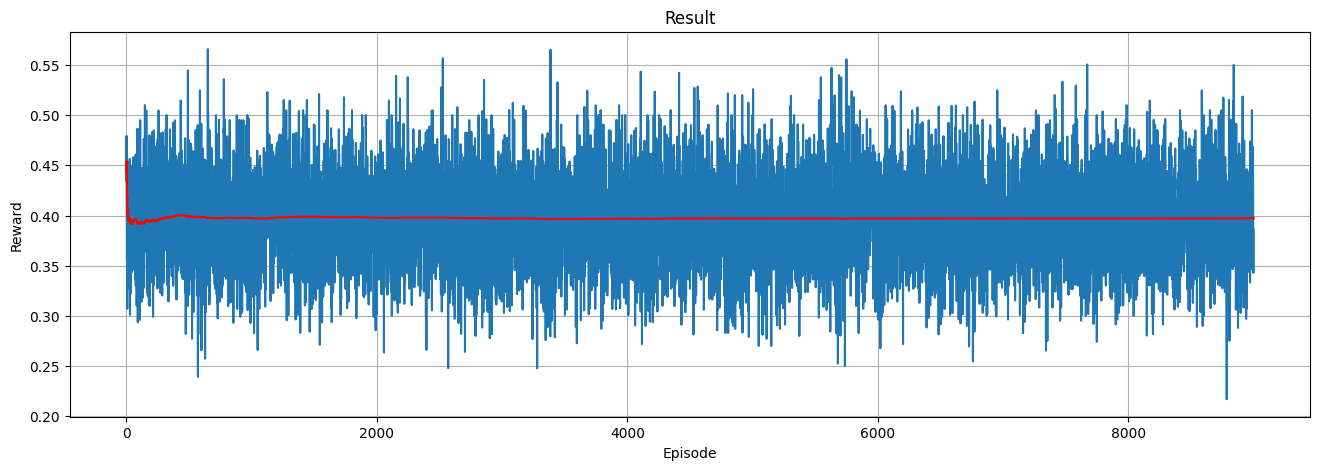

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
for i_episode in range(num_episodes):
    # Initialize the environment and state
    sum_reward = 0
    log_probs = []
    values = []
    rewards = []
    confusion_matrix = np.zeros((2,2), dtype=int)


    initial_state, info = train_env.reset()
    state = torch.tensor(initial_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        # select action
        action, value, log_prob = select_action(state)
        log_probs.append(log_prob)
        values.append(value)

        # calculate next state
        raw_next_state, reward, terminated, truncated, info = train_env.step(action.item())
        row_column_index = info["confusion_position"]
        confusion_matrix[row_column_index[0], row_column_index[1]] += 1
        rewards.append(reward)

        # to tensor
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        # store the transition in memory
        memory.push(state, action, next_state, reward)
        sum_reward += reward.item() if reward.item() == 1 else 0

        # move to the next state
        state = next_state

        if terminated:
            episode_rewards.append(sum_reward / (t + 1))
            break

    # do after the episode
    
    # optimize the model
    # optimize
    cumulative_reward = 0
    discounted_rewards = []
    for r in reversed(rewards):
        cumulative_reward = r + GAMMA * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)
    
    discounted_rewards = torch.tensor(discounted_rewards)
    values = torch.cat(values).squeeze()
    advantages = discounted_rewards - values.detach()

    actor_loss = - (torch.stack(log_probs) * advantages).sum()
    critic_loss = nn.functional.mse_loss(values, discounted_rewards)
    loss = actor_loss + critic_loss

    model_optimizer.zero_grad()
    loss.backward()
    model_optimizer.step()

    base = confusion_matrix[0, 0] + confusion_matrix[1, 0]
    episode_precision.append(
        confusion_matrix[0,0] / base if base != 0 else 0.0
    )

    if i_episode > 0 and i_episode % 50 == 0:
        plot_rewards(episode_rewards)

# complete the episode
plot_rewards(episode_rewards, show_result=True)
torch.save(model.state_dict(), "a2c_no2.pth")  # save the model

train_env.close()

## Test the model

901 4738 5257 0
909 4782 5309 0
913 4831 5383 0
920 4874 5456 0
929 4924 5516 0
937 4969 5563 0
945 5005 5618 0
952 5060 5666 0
960 5111 5723 0


<Figure size 640x480 with 0 Axes>

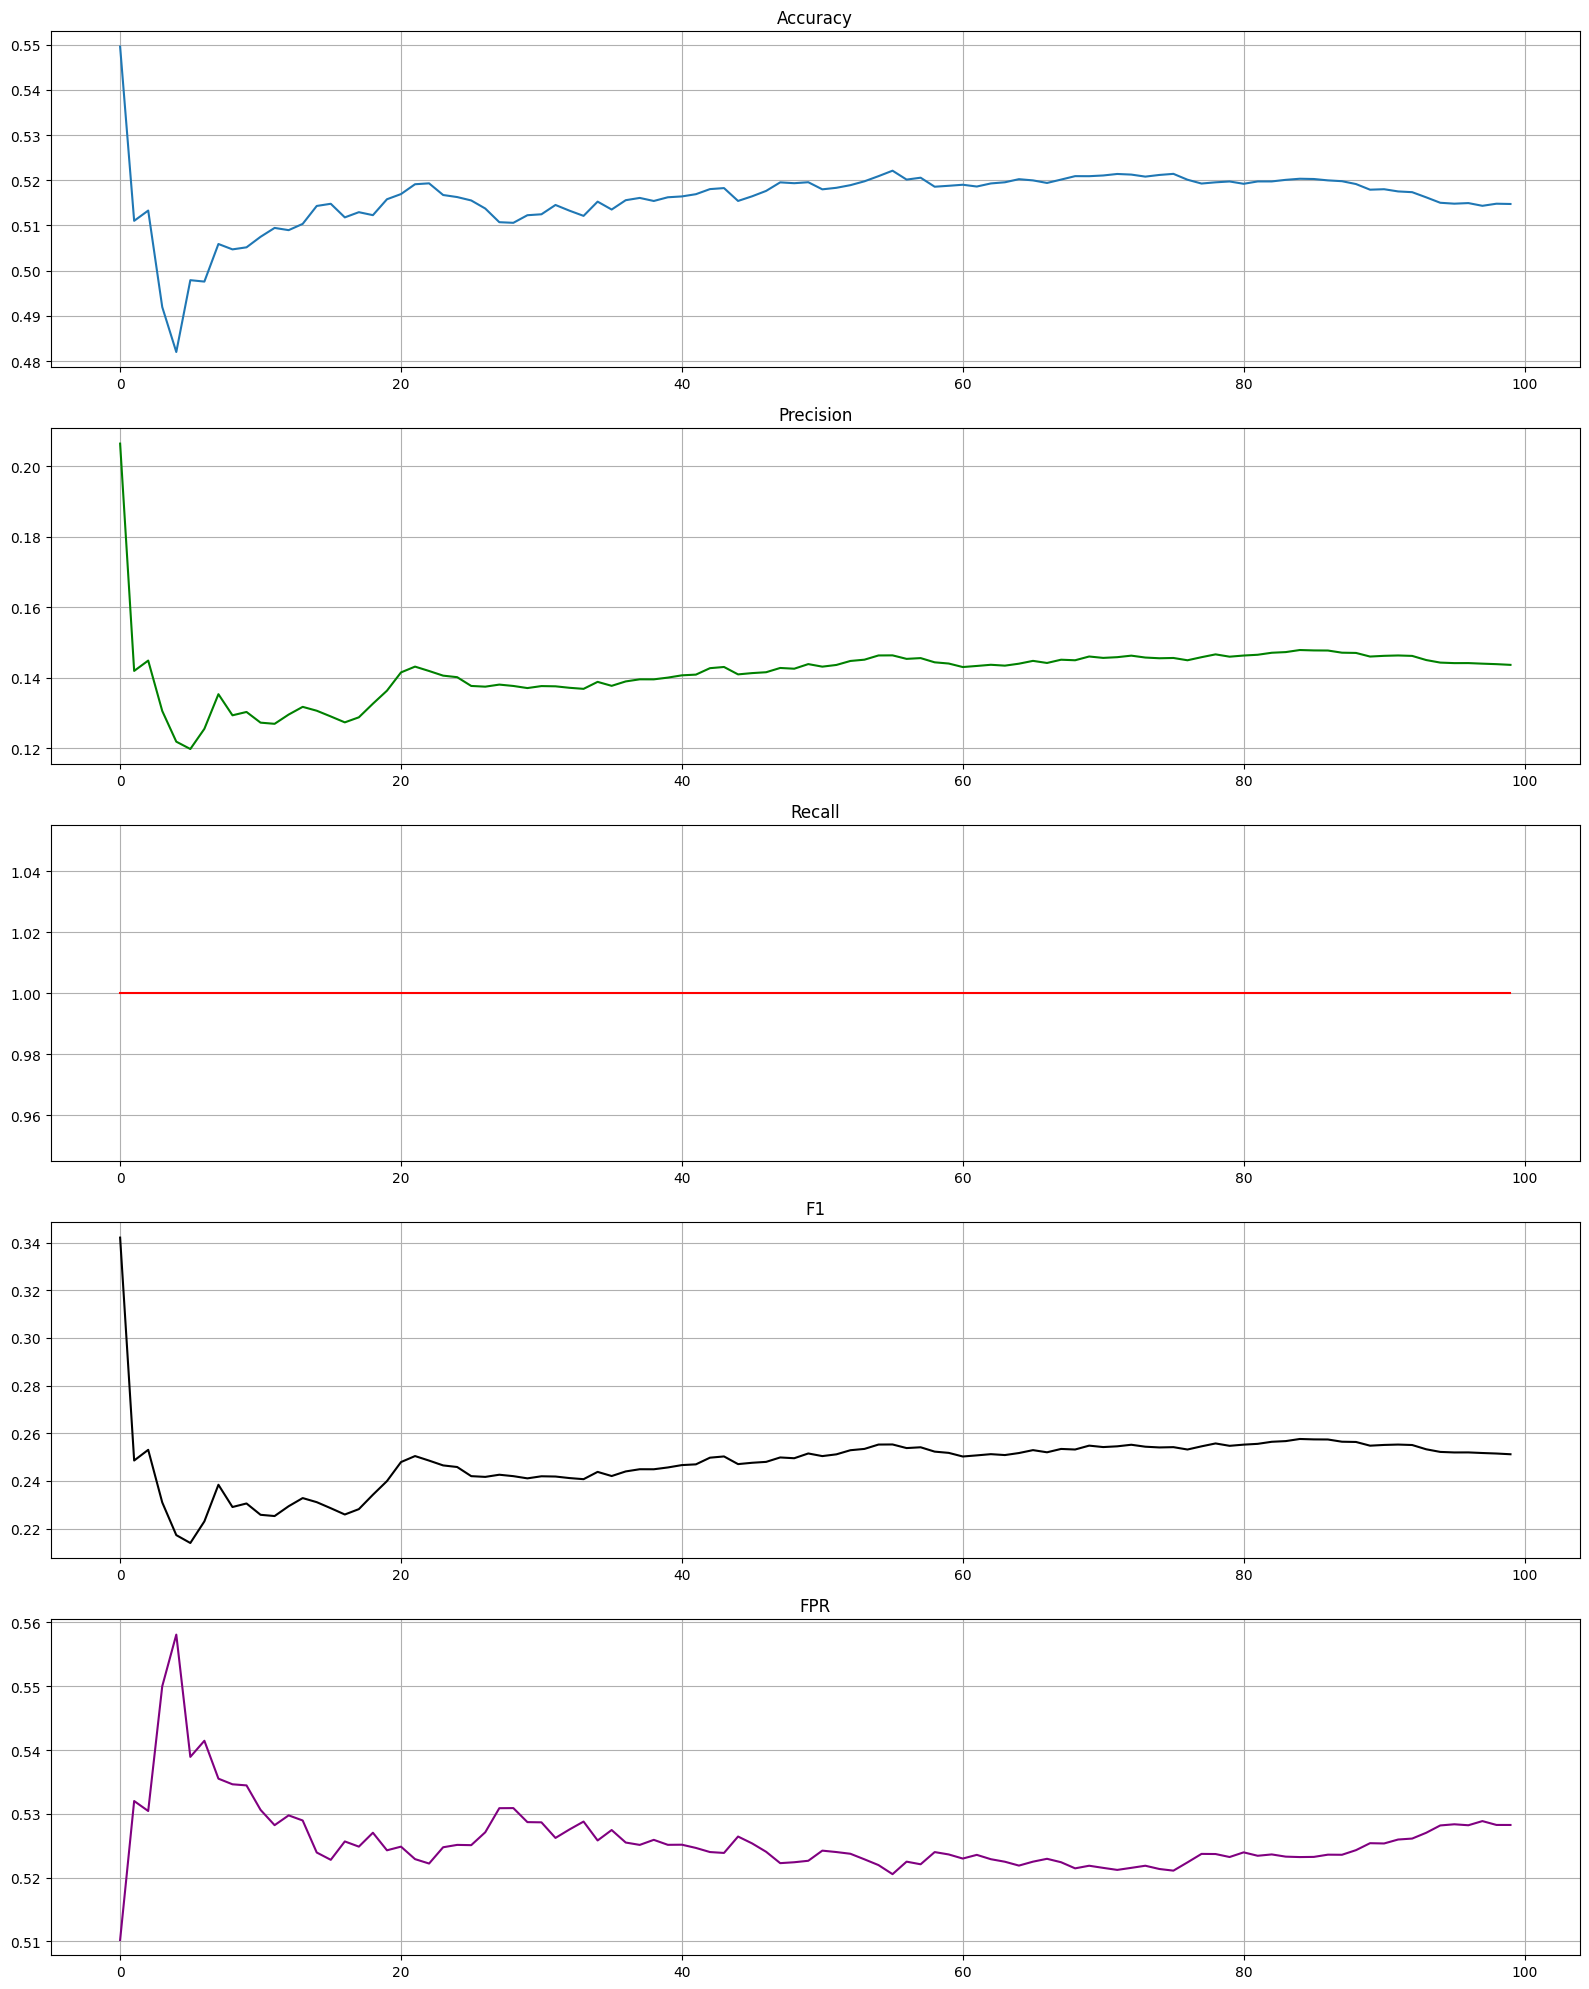

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
MODEL_PATH = "a2c_no2.pth"

# TODO: load the model
# load the model
trained_network = A2CNetwork(n_inputs, n_outputs)
trained_network.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
trained_network.eval()

# test the model

confusion_array = np.zeros((2, 2), dtype=np.int32)
metrics_dictionary = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}

for i_loop in range(100):
    test_raw_state, _ = test_env.reset()
    test_state = torch.tensor(test_raw_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        with torch.no_grad():
            policy, _ = trained_network(test_state)
            action_dist = torch.distributions.Categorical(policy)
            test_action = action_dist.sample()

        test_raw_next_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action.item())

        # calculate confusion matrix
        raw = 0 if test_reward == 1 else 1

        # test_info = (row, column) means confusion matrix index
        index = test_info["confusion_position"]
        confusion_array[index[0], index[1]] += 1

        if test_terminated:
            break

        # make next state tensor and update state
        test_state = torch.tensor(test_raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)

    # calculate metrics
    tp = confusion_array[0, 0]
    tn = confusion_array[1, 1]
    fp = confusion_array[0, 1]
    fn = confusion_array[1, 0]

    accuracy, precision, recall, f1, fpr = calculate_metrics(tp, tn, fp, fn)
    metrics_dictionary["accuracy"].append(accuracy)
    metrics_dictionary["precision"].append(precision)
    metrics_dictionary["recall"].append(recall)
    metrics_dictionary["f1"].append(f1)
    metrics_dictionary["fpr"].append(fpr)
    print(tp, tn, fp, fn)

    if i_loop % 10 == 0:
        plot_metrics(metrics_dictionary)

# plot metrics
plot_metrics(metrics_dictionary, show_result=True)